# ASSAM RAINFALL TREND ANALYSIS




Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### INSTALLING NECESSARY LIBRARIES

In [ ]:
!pip install geopandas

In [ ]:
!pip install tslearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 369.8/369.8 kB 6.3 MB/s eta 0:00:00


In [ ]:
!pip install fastdtw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=512576 sha256=3fa8cac95c77230fbb71e0e6fdad80aa6dbad7852cb903980d36dd9b838cf74c
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


In [ ]:
!pip install pymannkendall

In [ ]:
!pip install pyhomogeneity

In [ ]:
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

import pyproj
from shapely.geometry import Point

import pandas as pd

from fastdtw import fastdtw

from scipy.stats import kendalltau, norm, linregress, zscore

import pyhomogeneity as hg

### IMPLEMENTATION

IMPORTING INDIAN METEROLOGICAL DEPARTMENT (IMD) RAINFALL DATASETS 2022 TO 1901

In [ ]:
data_path = '/content/drive/MyDrive/ColabNotebooks/IMD-FINAL-YEAR-PROJECT/Rainfall-dataset-2022to1901/'

In [ ]:
rainfall_data_2001 = xr.open_dataset(data_path + '2001.nc')
print(rainfall_data_2001.head())

<xarray.Dataset>
Dimensions:    (LONGITUDE: 5, LATITUDE: 5, TIME: 5)
Coordinates:
  * LONGITUDE  (LONGITUDE) float64 66.5 67.5 68.5 69.5 70.5
  * LATITUDE   (LATITUDE) float64 6.5 7.5 8.5 9.5 10.5
  * TIME       (TIME) datetime64[ns] 2001-01-01 2001-01-02 ... 2001-01-05
Data variables:
    RAINFALL   (TIME, LATITUDE, LONGITUDE) float64 ...
Attributes:
    history:      FERRET V7.5 (optimized) 28-Mar-22
    Conventions:  CF-1.6


PRINTING THE LATITUDNAL AND LONGITUDNAL RANGE OF THE RAINFALL DATASETS

In [ ]:
# Access the longitude and latitude coordinates from the dataset
longitude_values = rainfall_data_2001['LONGITUDE'].values
latitude_values = rainfall_data_2001['LATITUDE'].values

# Find the minimum and maximum values for longitude and latitude
min_longitude = longitude_values.min()
max_longitude = longitude_values.max()
min_latitude = latitude_values.min()
max_latitude = latitude_values.max()

# Print the range of longitude and latitude
print(f"Longitude Range: ({min_longitude}, {max_longitude})")
print(f"Latitude Range: ({min_latitude}, {max_latitude})")

Longitude Range: (66.5, 100.5)
Latitude Range: (6.5, 38.5)


In [ ]:
print(f"Latitude values: {latitude_values}", "\n")

print(f"Longitude values: {longitude_values}")

Latitude values: [ 6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5 18.5 19.5
 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5
 34.5 35.5 36.5 37.5 38.5] 

Longitude values: [ 66.5  67.5  68.5  69.5  70.5  71.5  72.5  73.5  74.5  75.5  76.5  77.5
  78.5  79.5  80.5  81.5  82.5  83.5  84.5  85.5  86.5  87.5  88.5  89.5
  90.5  91.5  92.5  93.5  94.5  95.5  96.5  97.5  98.5  99.5 100.5]


IMPORTING THE SHAPEFILE OF INDIA

In [ ]:
India_shapefile_path = '/content/drive/MyDrive/ColabNotebooks/IMD-FINAL-YEAR-PROJECT/india_district/india_district.shp'
India_shapefile = gpd.read_file(India_shapefile_path)
print(India_shapefile)

     censuscode    district  dt_cen_cd  st_cen_cd           st_nm  \
0         536.0   Hyderabad          5         28  Andhra Pradesh   
1         494.0         Diu          1         25     Daman & Diu   
2          91.0       North          2          7    NCT of Delhi   
3         191.0    AZAMGARH         61          9   Uttar Pradesh   
4           NaN       HAPUR         73          9   Uttar Pradesh   
..          ...         ...        ...        ...             ...   
640       146.0        AGRA         15          9   Uttar Pradesh   
641       166.0      JHANSI         36          9   Uttar Pradesh   
642       167.0    LALITPUR         37          9   Uttar Pradesh   
643       171.0  CHITRAKOOT         41          9   Uttar Pradesh   
644       199.0    MIRZAPUR         69          9   Uttar Pradesh   

                                              geometry  
0    POLYGON ((78.51164 17.45434, 78.54018 17.46267...  
1                                                 None  


In [ ]:
print(India_shapefile['st_nm'].unique())

['Andhra Pradesh' 'Daman & Diu' 'NCT of Delhi' 'Uttar Pradesh'
 'West Bengal' 'Assam' 'Jharkhand' 'Puducherry' 'Tamil Nadu'
 'Jammu & Kashmir' 'Haryana' 'Odisha' 'Bihar' 'Nagaland'
 'Himachal Pradesh' 'Manipur' 'Maharashtra' 'Kerala' 'Madhya Pradesh'
 'Punjab' 'Rajasthan' 'Sikkim' 'Karnataka' 'Chhattisgarh' 'Gujarat'
 'Uttarakhand' 'Mizoram' 'Goa' 'Meghalaya' 'Arunanchal Pradesh'
 'Chandigarh' 'Tripura' 'Andaman & Nicobar Island' 'Lakshadweep'
 'Dadara & Nagar Havelli']






FILTERING ASSAM'S GEODATAFRAME FROM THE SHAPEFILE OF INDIA

In [ ]:
# Filter the GeoDataFrame to get the State polygon
assam_shapefile = India_shapefile[India_shapefile['st_nm'] == 'Assam']
print(assam_shapefile)

     censuscode             district  dt_cen_cd  st_cen_cd  st_nm  \
6         304.0             Marigaon          5         18  Assam   
17        317.0            Karimganj         18         18  Assam   
131       324.0                Baksa         25         18  Assam   
155       312.0               Jorhat         13         18  Assam   
208       313.0             Golaghat         14         18  Assam   
210       326.0             Udalguri         27         18  Assam   
301       321.0               Kamrup         22         18  Assam   
310       305.0               Nagaon          6         18  Assam   
316       325.0              Darrang         26         18  Assam   
321       323.0              Nalbari         24         18  Assam   
328       303.0              Barpeta          4         18  Assam   
358       316.0               Cachar         17         18  Assam   
370       301.0               Dhubri          2         18  Assam   
377       300.0            Kokrajh

PRINTING THE LATITUDNAL AND LONGITUDNAL RANGE OF ASSAM

In [ ]:
# Extract the geometry of the state polygon
assam_geometry = assam_shapefile['geometry'].iloc[0]

# Get the bounding box (envelope) of the Assam polygon
assam_bbox = assam_geometry.bounds

# Extract latitude and longitude range
min_longitude, min_latitude, max_longitude, max_latitude = assam_bbox

print(f"Latitude Range: {min_latitude} to {max_latitude}")
print(f"Longitude Range: {min_longitude} to {max_longitude}")


Latitude Range: 26.060842 to 26.516747
Longitude Range: 91.955979 to 92.551448


In [ ]:
min_longitude, min_latitude, max_longitude, max_latitude = 89.7,22.31,96.5,28.26

print(f"Latitude Range: {min_latitude} to {max_latitude}")
print(f"Longitude Range: {min_longitude} to {max_longitude}")

Latitude Range: 22.31 to 28.26
Longitude Range: 89.7 to 96.5


AVERAGE DAILY RAINFALL OF ASSAM FROM 2022 TO 1901

In [ ]:
for year in range(2022, 1900, -1):
  rainfall_data = xr.open_dataset(data_path + f'{year}.nc')
  # Find latitude and longitude indices within the State's boundaries
  latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
  longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

  # Slice the rainfall data for the state
  assam_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
  #Calculate the average and sum rainfall for each day over the entire time range
  average_rainfall_per_day = np.mean(assam_rainfall_data, axis=(1, 2))
  sum_rainfall_per_day = np.sum(assam_rainfall_data, axis=(1, 2))
  # Plot the average rainfall for each day using a line plot
  plt.figure(figsize=(12, 6))
  plt.plot(np.arange(1, len(average_rainfall_per_day) + 1),average_rainfall_per_day , marker='o', linestyle='-', color='b')
  plt.xlabel('Day of the Year')
  plt.ylabel('Average Rainfall (mm)')
  plt.title(f'Average Daily Rainfall in ASSAM for {year}')
  plt.grid(True)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

SUM DAILY RAINFALL OF ASSAM FROM 2022 TO 1901

In [ ]:
for year in range(2022, 1900, -1):
  rainfall_data = xr.open_dataset(data_path + f'{year}.nc')
  # Find latitude and longitude indices within the State's boundaries
  latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
  longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

  # Slice the rainfall data for the state
  assam_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
  #Calculate the average and sum rainfall for each day over the entire time range
  average_rainfall_per_day = np.mean(assam_rainfall_data, axis=(1, 2))
  sum_rainfall_per_day = np.sum(assam_rainfall_data, axis=(1, 2))
  # Plot the sum rainfall for each day using a line plot
  plt.figure(figsize=(12, 6))
  plt.plot(np.arange(1, len(sum_rainfall_per_day) + 1),sum_rainfall_per_day , marker='o', linestyle='-', color='b')
  plt.xlabel('Day of the Year')
  plt.ylabel('Sum Rainfall (mm)')
  plt.title(f'Sum Daily Rainfall in Assam for {year}')
  plt.grid(True)
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

 MONTHLY RAINFALL OF ASSAM FROM 2022 TO 1901 (Using average daily rainfall)

In [ ]:
for year in range(2022, 1900, -1):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Find latitude and longitude indices within the State's boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for State
    assam_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
    average_rainfall_per_day = np.mean(assam_rainfall_data, axis=(1, 2))
    # Resample the data to monthly rainfall
    assam_monthly_rainfall = average_rainfall_per_day.resample(TIME='1M').sum()

    y_data = assam_monthly_rainfall.values.squeeze()

    # Plot the monthly rainfall using a line plot
    plt.figure(figsize=(12, 6))
    plt.plot(months, y_data, marker='o', linestyle='-', color='b')
    plt.xlabel('Month')
    plt.ylabel('Rainfall (mm)')
    plt.title(f'Monthly Rainfall in ASSAM for {year}')
    plt.grid(True)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

AVERAGE MONTHLY RAINFALL OF ASSAM FROM 2022 TO 1901 (Using average daily rainfall)

In [ ]:
for year in range(2022, 1900, -1):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Find latitude and longitude indices within the state boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for state
    assam_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]
    average_rainfall_per_day = np.mean(assam_rainfall_data, axis=(1, 2))
    # Resample the data to monthly averages
    assam_monthly_average_rainfall = average_rainfall_per_day.resample(TIME='1M').mean()

    y_data = assam_monthly_average_rainfall.values.squeeze()

    # Plot the average monthly rainfall using a line plot
    plt.figure(figsize=(12, 6))
    plt.plot(months, y_data, marker='o', linestyle='-', color='b')
    plt.xlabel('Month')
    plt.ylabel('Average Rainfall (mm)')
    plt.title(f'Average Monthly Rainfall in ASSAM for {year}')
    plt.grid(True)
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

 DYNAMIC TIME WARPING (DTW) FOR ANALYSING THE SIMILARITY OF MONTHLY AVERAGE RAINFALL FROM 2022 TO 1901.
 ##### Lowest peaks : Highest similarity (vice versa)

In [ ]:
for year1 in range(2022,1900,-1):
  dfs = []
  # Load the rainfall data for the current years
  rainfall_data1 = xr.open_dataset(data_path + f'{year1}.nc')

  # Find latitude and longitude indices within the State's boundaries
  latitude_indices1 = np.where((rainfall_data1['LATITUDE'] >= min_latitude) & (rainfall_data1['LATITUDE'] <= max_latitude))[0]
  longitude_indices1 = np.where((rainfall_data1['LONGITUDE'] >= min_longitude) & (rainfall_data1['LONGITUDE'] <= max_longitude))[0]

  # Slice the rainfall data for State
  assam_rainfall_data1 = rainfall_data1['RAINFALL'][:, latitude_indices1, longitude_indices1]
  average_rainfall_per_day1 = np.mean(assam_rainfall_data1, axis=(1, 2))
  # Resample the data to monthly averages
  assam_monthly_average_rainfall1 = average_rainfall_per_day1.resample(TIME='1M').mean()

  for year2 in range(year1-1,1900,-1):

    # Load the rainfall data for the current years
    rainfall_data2 = xr.open_dataset(data_path + f'{year2}.nc')

    # Find latitude and longitude indices within the State's boundaries
    latitude_indices2 = np.where((rainfall_data2['LATITUDE'] >= min_latitude) & (rainfall_data2['LATITUDE'] <= max_latitude))[0]
    longitude_indices2 = np.where((rainfall_data2['LONGITUDE'] >= min_longitude) & (rainfall_data2['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for state
    assam_rainfall_data2 = rainfall_data2['RAINFALL'][:, latitude_indices2, longitude_indices2]
    average_rainfall_per_day2 = np.mean(assam_rainfall_data2, axis=(1, 2))
    # Resample the data to monthly averages
    assam_monthly_average_rainfall2 = average_rainfall_per_day2.resample(TIME='1M').mean()

    dtw_distance, _ = fastdtw(assam_monthly_average_rainfall1, assam_monthly_average_rainfall2)

    # Store the DTW distance and the corresponding year
    dfs.append({'Year': year2, 'DTW Distance': dtw_distance})

    # Create a DataFrame from the list of dictionaries
    result_df = pd.DataFrame(dfs)

  # Plot the DTW distances
  plt.figure(figsize=(40, 6))
  plt.plot(result_df['Year'], result_df['DTW Distance'], marker='o', linestyle='-', color='b')
  plt.xlabel('Years')
  plt.ylabel('DTW Distance')
  plt.title(f'Similarity of ASSAM\'s Average Monthly Rainfall of {year1} ')
  plt.xticks(np.arange(min(result_df['Year']), max(result_df['Year']) + 1, 1), rotation=45, ha='right')
  plt.grid(True)
  plt.show()


Output hidden; open in https://colab.research.google.com to view.

MONTHLY RAINFALL & TOTAL ANNUAL RAINFALL FROM 1901 TO 2022

In [ ]:
dfs = []

for year in range(1901, 2023):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Find latitude and longitude indices within the state's boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for the state
    assam_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]

    # Resample the data to monthly averages
    #sikkim_monthly_sum_rainfall = sikkim_rainfall_data.resample(TIME='1M').sum()
    average_rainfall_per_day = np.mean(assam_rainfall_data, axis=(1, 2))
    assam_monthly_rainfall = average_rainfall_per_day.resample(TIME='1M').sum()
    df_year = pd.DataFrame({
        'Year': [year] * len(assam_monthly_rainfall['TIME']),
        'Month': assam_monthly_rainfall['TIME'].dt.strftime('%b'),
        'Monthly Rainfall': assam_monthly_rainfall.values.flatten()
    })

    # Append the DataFrame to the list
    dfs.append(df_year)

# Concatenate all DataFrames into a single DataFrame
result_df = pd.concat(dfs, ignore_index=True)

# Pivot the DataFrame to have months as columns
result_df_pivoted = result_df.pivot_table(index='Year', columns='Month', values='Monthly Rainfall', aggfunc='sum', fill_value=0)

# Add a column for Total Annual Rainfall
result_df_pivoted['Total Annual Rainfall'] = result_df_pivoted.sum(axis=1)

# Reset index to make 'Year' a column again
result_df_pivoted = result_df_pivoted.reset_index()

# Display the resulting DataFrame
print(result_df_pivoted)

Month  Year         Apr         Aug        Dec        Feb        Jan  \
0      1901  143.616508  381.577019   0.381177   8.623393   5.442168   
1      1902  264.494928  383.690144   0.435359   8.376627   2.531698   
2      1903   60.124524  361.651222   2.444635  18.018914   7.068144   
3      1904  294.264901  438.118968   1.664201  32.840988   5.306646   
4      1905  225.804059  645.075961  24.196555  11.691390   4.607398   
..      ...         ...         ...        ...        ...        ...   
117    2018  138.234396  252.200514  29.122376  13.359426   8.690491   
118    2019  153.803794  224.951798   2.671949  51.277056   3.088896   
119    2020   64.474143  356.721574   2.912924   9.682382  24.927083   
120    2021   60.183127  359.795830  29.163146   0.983257  12.728438   
121    2022  234.944341  175.213347   8.526476  40.732097  16.386737   

Month         Jul         Jun         Mar         May        Nov         Oct  \
0      188.579284  783.418217    8.875865   96.757560  

MEAN, STANDARD DEVIATION, RANGE OF TOTAL ANNUAL RAINFALL, POINT OF HIGHEST AND LOWEST RAINFALL

In [ ]:
mean = np.mean(result_df_pivoted['Total Annual Rainfall'] )
std = np.std(result_df_pivoted['Total Annual Rainfall'] )
print(f"Mean of Total Annual Rainfall: {mean} mm")
print(f"Standard deviation of Total Annual Rainfall: {std} mm")
print(f"Range of Total Annual Rainfall: {mean - std}mm <= Rainfall <= {mean + std}mm")
print('\n')
max_rainfall_year = result_df_pivoted.loc[result_df_pivoted['Total Annual Rainfall'].idxmax(), 'Year']
max_rainfall_value = result_df_pivoted['Total Annual Rainfall'].max()

print(f"Year with the Highest Rainfall: {max_rainfall_year}")
print(f"Highest Rainfall Value: {max_rainfall_value} mm")
print('\n')
min_rainfall_year = result_df_pivoted.loc[result_df_pivoted['Total Annual Rainfall'].idxmin(), 'Year']
min_rainfall_value = result_df_pivoted['Total Annual Rainfall'].min()

print(f"Year with the Lowest Rainfall: {min_rainfall_year}")
print(f"Lowest Rainfall Value: {min_rainfall_value} mm")

Mean of Total Annual Rainfall: 2179.5757200638673 mm
Standard deviation of Total Annual Rainfall: 383.28565236270055 mm
Range of Total Annual Rainfall: 1796.2900677011667mm <= Rainfall <= 2562.861372426568mm


Year with the Highest Rainfall: 1948
Highest Rainfall Value: 3037.6659208132096 mm


Year with the Lowest Rainfall: 2010
Lowest Rainfall Value: 856.6586087294496 mm


TOTAL ANNUAL RAINFALL ANALYSIS FROM 1901 TO 2022

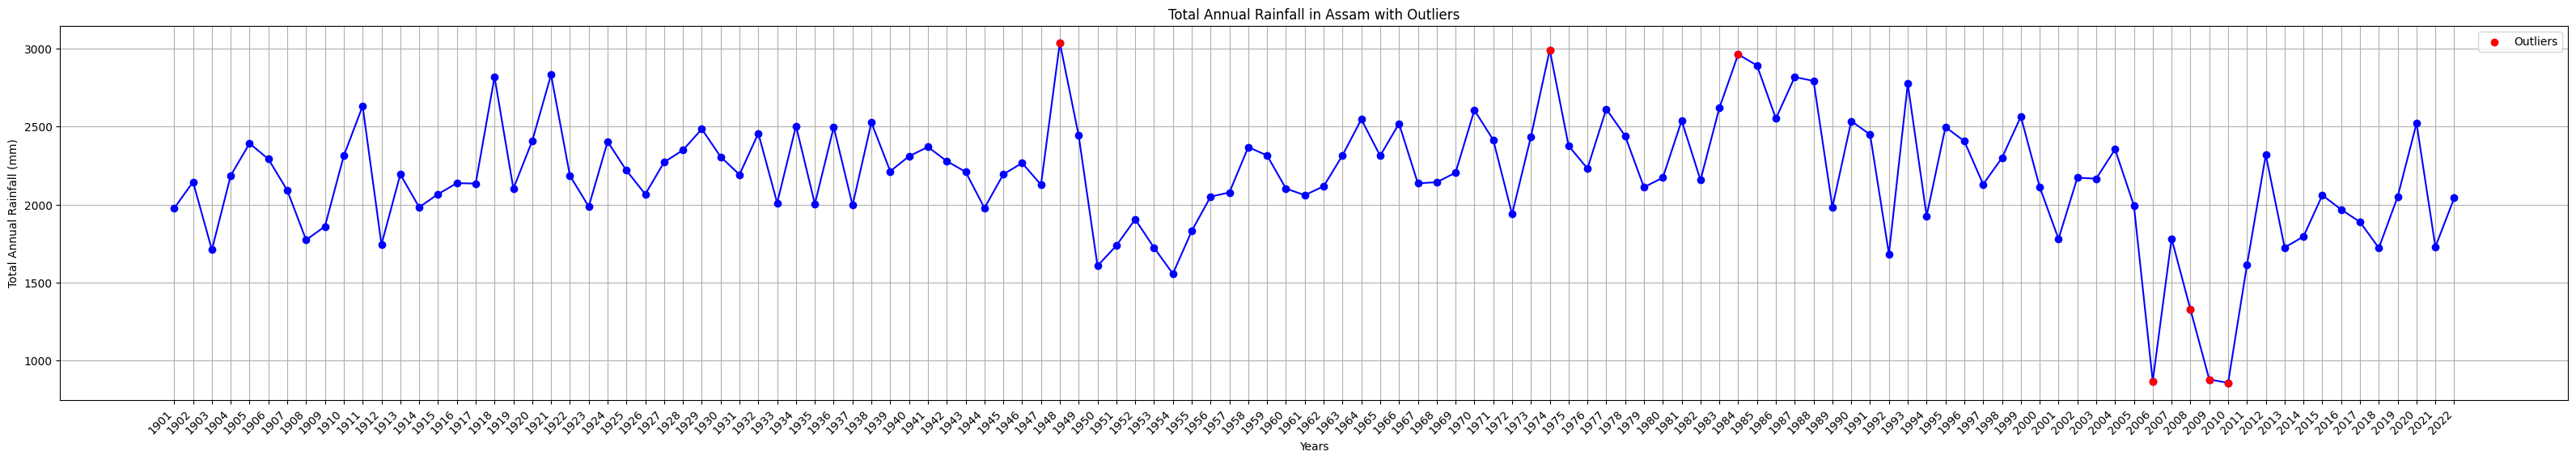

Number of Outliers: 7
Outlier Years: [1948, 1974, 1984, 2006, 2008, 2009, 2010]
Outlier Values: [3037.6659208132096, 2991.6925464080505, 2962.837105532679, 867.1384816674087, 1327.0820691892159, 878.3830523634186, 856.6586087294496]


In [ ]:
# Calculate the Z-scores for the 'Total Annual Rainfall' column
z_scores = zscore(result_df_pivoted['Total Annual Rainfall'])

# Define a threshold for identifying outliers (e.g., Z-score greater than 2)
outlier_threshold = 2

# Identify outlier indices
outlier_indices = np.where(np.abs(z_scores) > outlier_threshold)[0]

# Plot the line graph with outliers highlighted
plt.figure(figsize=(40, 6))
plt.plot(result_df_pivoted['Year'], result_df_pivoted['Total Annual Rainfall'], marker='o', linestyle='-', color='b')
plt.scatter(result_df_pivoted['Year'].iloc[outlier_indices], result_df_pivoted['Total Annual Rainfall'].iloc[outlier_indices], color='r', label='Outliers',  zorder=5)
plt.xlabel('Years')
plt.ylabel('Total Annual Rainfall (mm)')
plt.title('Total Annual Rainfall in Assam with Outliers')
plt.xticks(np.arange(min(result_df_pivoted['Year']), max(result_df_pivoted['Year']) + 1, 1), rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.show()

# Print information about outliers
print(f"Number of Outliers: {len(outlier_indices)}")
print(f"Outlier Years: {result_df_pivoted['Year'].iloc[outlier_indices].tolist()}")
print(f"Outlier Values: {result_df_pivoted['Total Annual Rainfall'].iloc[outlier_indices].tolist()}")

DECADAL AVERAGE ANNUAL RAINFALL 1900 TO 2020

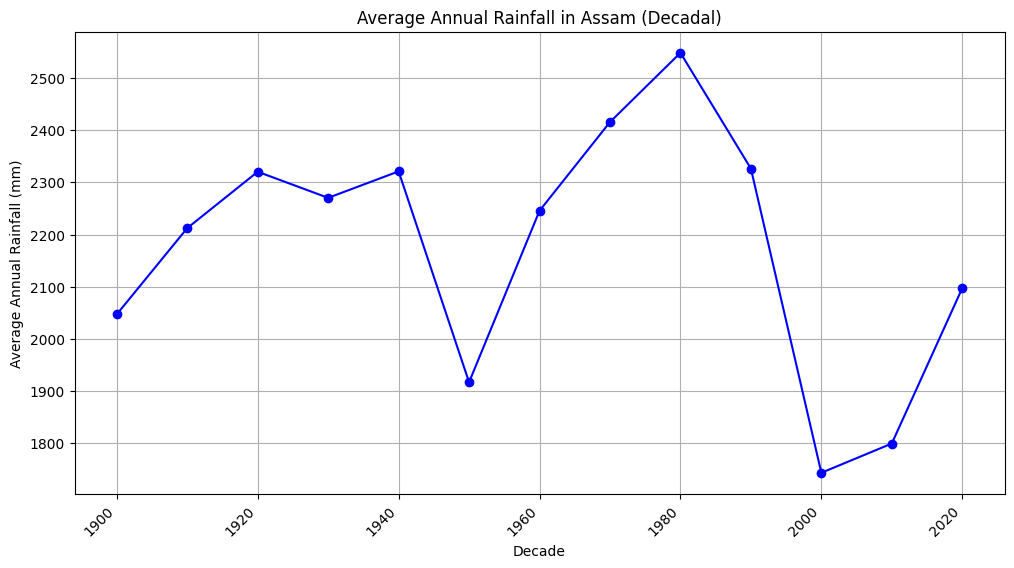

Mean Annual Rainfall: 2174.1203175073974 mm
Standard Deviation of Annual Rainfall: 240.59086637911375 mm


In [ ]:
# Calculate average annual rainfall across each 10 years
result_df_pivoted['Decade'] = (result_df_pivoted['Year'] // 10) * 10
decadal_average_rainfall = result_df_pivoted.groupby('Decade')['Total Annual Rainfall'].mean()

# Plot the decadal average annual rainfall as a line plot
plt.figure(figsize=(12, 6))
plt.plot(decadal_average_rainfall.index, decadal_average_rainfall, marker='o', color='b', linestyle='-')
plt.xlabel('Decade')
plt.ylabel('Average Annual Rainfall (mm)')
plt.title(f'Average Annual Rainfall in Assam (Decadal)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

# Print the mean and standard deviation
mean_rainfall = decadal_average_rainfall.mean()
std_rainfall = decadal_average_rainfall.std()

print(f"Mean Annual Rainfall: {mean_rainfall} mm")
print(f"Standard Deviation of Annual Rainfall: {std_rainfall} mm")

YEARS WITH AVERAGE ANNUAL RAINFALL ABOVE 95TH PERCENTILE AND BELOW 5TH PERCENTILE

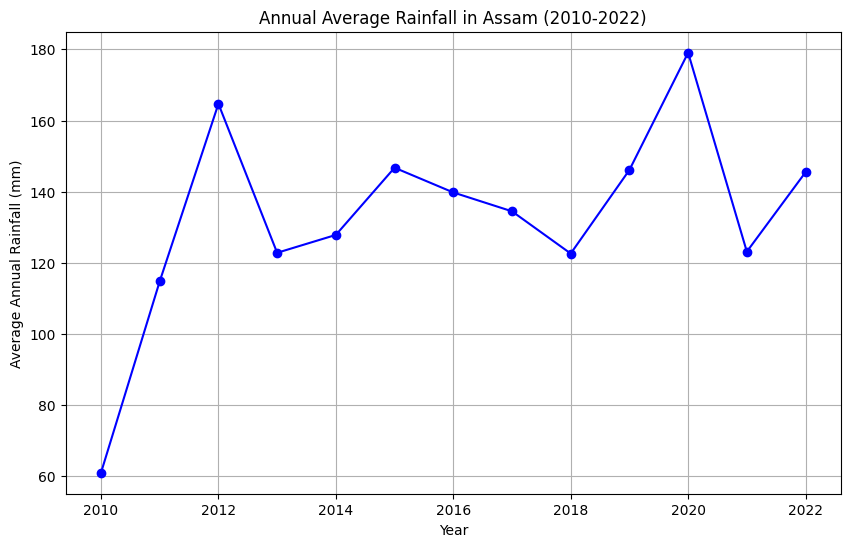

Years above 95th percentile: [2020]
Years below 5th percentile: [2010]


In [ ]:
# Initialize an empty list to store annual average rainfall
annual_averages = []

# Loop through each year in the specified range (2010 to 2022)
for year in range(2010, 2023):
    # Load the rainfall data for the current year
    rainfall_data = xr.open_dataset(data_path + f'{year}.nc')

    # Find latitude and longitude indices within Assam's boundaries
    latitude_indices = np.where((rainfall_data['LATITUDE'] >= min_latitude) & (rainfall_data['LATITUDE'] <= max_latitude))[0]
    longitude_indices = np.where((rainfall_data['LONGITUDE'] >= min_longitude) & (rainfall_data['LONGITUDE'] <= max_longitude))[0]

    # Slice the rainfall data for Assam
    Assam_rainfall_data = rainfall_data['RAINFALL'][:, latitude_indices, longitude_indices]

    # Calculate the annual average rainfall
    annual_average_rainfall = Assam_rainfall_data.mean(dim='TIME').sum().item()
    annual_averages.append(annual_average_rainfall)

    # Close the NetCDF dataset to free up resources
    rainfall_data.close()

# Plot the annual average rainfall
plt.figure(figsize=(10, 6))
plt.plot(range(2010, 2023), annual_averages, marker='o', linestyle='-', color='b')
plt.xlabel('Year')
plt.ylabel('Average Annual Rainfall (mm)')
plt.title('Annual Average Rainfall in Assam (2010-2022)')
plt.grid(True)
plt.show()

# Calculate percentiles
percentile_5 = np.percentile(annual_averages, 5)
percentile_95 = np.percentile(annual_averages, 95)

# Print years above 95th percentile
above_95 = [year for year, avg in zip(range(2010, 2023), annual_averages) if avg > percentile_95]
print(f'Years above 95th percentile: {above_95}')

# Print years below 5th percentile
below_5 = [year for year, avg in zip(range(2010, 2023), annual_averages) if avg < percentile_5]
print(f'Years below 5th percentile: {below_5}')

MONTHLY RAINFALL ANALYSIS FROM 1901 TO 2022

In [ ]:
for month in months:
  # Calculate the Z-scores for the 'month' column
  z_scores = zscore(result_df_pivoted[month])

  # Define a threshold for identifying outliers (e.g., Z-score greater than 2)
  outlier_threshold = 2

  # Identify outlier indices
  outlier_indices = np.where(np.abs(z_scores) > outlier_threshold)[0]

  # Plot the line graph with outliers highlighted
  plt.figure(figsize=(40, 6))
  plt.plot(result_df_pivoted['Year'], result_df_pivoted[month], marker='o', linestyle='-', color='b')
  plt.scatter(result_df_pivoted['Year'].iloc[outlier_indices], result_df_pivoted[month].iloc[outlier_indices], color='r', label='Outliers',  zorder=5)
  plt.xlabel('Years')
  plt.ylabel('Monthly Rainfall (mm)')
  plt.title(f'Monthly Rainfall in Assam on {month} with Outliers')
  plt.xticks(np.arange(min(result_df_pivoted['Year']), max(result_df_pivoted['Year']) + 1, 1), rotation=45, ha='right')
  plt.legend()
  plt.grid(True)
  plt.show()

  # Print information about outliers
  print(f"Number of Outliers: {len(outlier_indices)}")
  print(f"Outlier Years: {result_df_pivoted['Year'].iloc[outlier_indices].tolist()}")
  print(f"Outlier Values: {result_df_pivoted[month].iloc[outlier_indices].tolist()}")

Output hidden; open in https://colab.research.google.com to view.

MANN-KENDALL TEST AND SEN SLOPE ESTIMATOR FOR TREND ANALYSIS.
##### Mann-Kendall test : A non-parametric statistical test used to assess the presence of trends in time series data by evaluating the monotonicity of the data over time.

##### Sen Slope Estimator : A method for estimating the slope of a trend in time series data

In [ ]:
# Filter the DataFrame for the desired years (2022 to 2012)
print("Enter the range of years(year1 to year2)")
year1 = int(input())
year2 = int(input())
selected_years = range(year1, year2 + 1)
df_selected_years = result_df_pivoted[result_df_pivoted['Year'].isin(selected_years)]

result, _ = kendalltau(df_selected_years['Year'],df_selected_years['Total Annual Rainfall'])

# Calculate p-value for the Mann-Kendall test
p_value = 2 * norm.cdf(-abs(result))

result_s = linregress(df_selected_years['Year'], df_selected_years['Total Annual Rainfall'])

# Display Mann-Kendall test result
print(f"Mann-Kendall Test Result for Yearly Sum of Rainfall ({year1} to {year2}):")
#print(f"Kendall's Tau: {result}")
print(f"P-value: {p_value}")

# Display Theil-Sen estimator result
print(f"Theil-Sen Estimator Result for Yearly Sum of Rainfall ({year1} to {year2}):")
print(f"Slope (Sen's Slope): {result_s.slope}")

if p_value < 0.05:
    if result_s.slope > 0:
        print("Significant positive trend")
    elif result_s.scope < 0:
        print("Significant negative trend")
    else:
        print("No significant trend")
else:
    print("No significant trend")

Enter the range of years(year1 to year2)
2020
2022
Mann-Kendall Test Result for Yearly Sum of Rainfall (2020 to 2022):
P-value: 0.7388826803635272
Theil-Sen Estimator Result for Yearly Sum of Rainfall (2020 to 2022):
Slope (Sen's Slope): -239.08898902254586
No significant trend


In [ ]:
# Filter the DataFrame for the desired years (2022 to 2012)
print("Enter the range of years(year1 to year2)")
year1 = int(input())
year2 = int(input())
selected_years = range(year1, year2 + 1)
df_selected_years =result_df_pivoted[result_df_pivoted['Year'].isin(selected_years)]

result, _ = kendalltau(df_selected_years['Year'],df_selected_years['Jan'])

# Calculate p-value for the Mann-Kendall test
p_value = 2 * norm.cdf(-abs(result))

result_s = linregress(df_selected_years['Year'], df_selected_years['Jan'])

# Display Mann-Kendall test result
print(f"Mann-Kendall Test Result for Monthly Rainfall of January ({year1} to {year2}):")
#print(f"Kendall's Tau: {result}")
print(f"P-value: {p_value}")

# Display Theil-Sen estimator result
print(f"Theil-Sen Estimator Result for Monthly Rainfall of January ({year1} to {year2}):")
print(f"Slope (Sen's Slope): {result_s.slope}")

if p_value < 0.05:
    if result_s.slope > 0:
        print("Significant positive trend")
    elif result_s.scope < 0:
        print("Significant negative trend")
    else:
        print("No significant trend")
else:
    print("No significant trend")

Enter the range of years(year1 to year2)
2019
2021
Mann-Kendall Test Result for Monthly Rainfall of January (2019 to 2021):
P-value: 0.7388826803635272
Theil-Sen Estimator Result for Monthly Rainfall of January (2019 to 2021):
Slope (Sen's Slope): 4.819770505508552
No significant trend


PETTITT TEST
##### A non-parametric statistical test used to detect a change point or discontinuity in a time series, indicating a significant shift in the distribution of the data.

In [ ]:
# Filter the DataFrame for the desired years (2022 to 2012)
print("Enter the range of years (year1 to year2)")
year1 = int(input())
year2 = int(input())
selected_years = range(year1, year2 + 1)
df_selected_years = result_df_pivoted[result_df_pivoted['Year'].isin(selected_years)]

# Perform Pettitt test for the selected years
result_pettitt = hg.pettitt_test(df_selected_years['Total Annual Rainfall'])

# Display Pettitt test result
print(f"Pettitt Test Result for Yearly Sum of Rainfall ({year1} to {year2}):")
print(f"Change detected: {result_pettitt.h}")
print(f"Change point index: {result_pettitt.cp}")
print(f"P-value: {result_pettitt.p}")
print(f"Test Statistic (U): {result_pettitt.U}")
print(f"Mean Before Change (mu1): {result_pettitt.avg.mu1}")
print(f"Mean After Change (mu2): {result_pettitt.avg.mu2}")

Enter the range of years (year1 to year2)
2019
2022
Pettitt Test Result for Yearly Sum of Rainfall (2019 to 2022):
Change detected: True
Change point index: 2
P-value: 0.0
Test Statistic (U): 4.0
Mean Before Change (mu1): 2285.7878090353825
Mean After Change (mu2): 1885.5448317203955


In [ ]:
# Filter the DataFrame for the desired years (2022 to 2012)
print("Enter the range of years (year1 to year2)")
year1 = int(input())
year2 = int(input())
selected_years = range(year1, year2 + 1)
df_selected_years = result_df_pivoted[result_df_pivoted['Year'].isin(selected_years)]

# Perform Pettitt test for the selected years
result_pettitt = hg.pettitt_test(df_selected_years['Jan'])

# Display Pettitt test result
print(f"Pettitt Test Result for Monthly Rainfall of January ({year1} to {year2}):")
print(f"Change detected: {result_pettitt.h}")
print(f"Change point index: {result_pettitt.cp}")
print(f"P-value: {result_pettitt.p}")
print(f"Test Statistic (U): {result_pettitt.U}")
print(f"Mean Before Change (mu1): {result_pettitt.avg.mu1}")
print(f"Mean After Change (mu2): {result_pettitt.avg.mu2}")

Enter the range of years (year1 to year2)
2020
2022
Pettitt Test Result for Monthly Rainfall of January (2020 to 2022):
Change detected: True
Change point index: 1
P-value: 0.0
Test Statistic (U): 2.0
Mean Before Change (mu1): 24.927082758110306
Mean After Change (mu2): 14.557587106067402
